# Generating median absolute deviations (MADs) <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a)


## Background

Median absolute deviation (MAD) is a robust measure of the variability within a dataset. 
For multi-spectral time-series data, MAD can be used to charaterise spectral variation through time, where the median is replaced by a geometric median. 

There are many options to measure vector distance (spectral difference) between observations. Three structurally different distance measures are chosen to compuate MAD through time for a location: the cosine distance, the Euclidean distance, and the Bray-Curtis distance.


## Description

TernaryMAD generates a 3-band output where the cosine distance MAD (SMAD, Band 1), the Euclidean distance MAD (EMAD, Band 2), the Bray-Curtis distance MAD (BCMAD, Band 3) are computed through time for every pixel. For this output, the distances are transformed by -log(x).

This notebook calculates TernaryMAD on Sentinel-2 data.


## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [1]:
%matplotlib inline

import datacube

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../Scripts')
from deafrica_datahandling import load_ard
from deafrica_plotting import rgb

### Install relevant package is needed

In [2]:
![ -d "datacube-2nd-order-stats" ] && echo "datacube-2nd-order-stats already installed"
![ ! -d "datacube-2nd-order-stats" ] && echo "datacube-2nd-order-stats not installed yet, run next cell"

datacube-2nd-order-stats already installed


%%time
!git clone https://github.com/daleroberts/datacube-2nd-order-stats
%cd datacube-2nd-order-stats
!cythonize model/fast.pyx
!gcc -shared -pthread -fopenmp -fPIC -O3 -fno-strict-aliasing -I$(python3 -c 'import numpy; print(numpy.get_include())') $(python3-config --includes) -Wno-cpp model/fast.c -o model/fast.so
%cd ..

In [3]:
sys.path.append('datacube-2nd-order-stats')
from model import TernaryMAD
#from model import SMAD, EMAD, BCMAD, TernaryMAD

### Connect to the datacube

In [4]:
dc = datacube.Datacube(app='mads')

## Load Sentinel-2 from the datacube

Here we are loading in a timeseries of cloud-masked Sentinel-2 satellite images through the datacube API using the [load_ard](../Frequently_used_code/Using_load_ard.ipynb) function. 
This will provide us with some data to work with. To limit computation and memory this example uses only three optical bands (red, green, blue).

In [5]:
# Set up centre of area of interest, and area to buffer coordinates by
lat, lon = -34.237505, 19.706921
buffer = 0.075

# Create a reusable query
query = {
    'x': (lon-buffer, lon+buffer),
    'y': (lat+buffer, lat-buffer),
    'time': ('2019-01', '2019-12'),
    'measurements': ['green',
                     'red',
                     'blue'],
    'resolution': (-20, 20),
    'group_by': 'solar_day',
    'output_crs': 'EPSG:6933'
}


Compared to the typical use of `load_ard` which by default returns data with floating point numbers containing `NaN` (i.e. `float32`), in this example we will set the `dtype` to `'native'`. 
This will keep our data in its original integer data type (i.e. `Int16`), with nodata values marked with `-999`. 
Doing this will halve the amount of memory our data takes up, which can be extremely valuable when conducting large-scale analyses.

Data will be converted to floating point during TMAD calculation.

In [6]:
# Load available data
ds = load_ard(dc=dc, 
              products=['s2_l2a'],
              #dask_chunks={'x':2000, 'y':2000},
              dtype='native',
              **query)

# Print output data
print(ds)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying pixel quality/cloud mask
Loading 72 time steps
<xarray.Dataset>
Dimensions:      (time: 72, x: 725, y: 795)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-01T08:49:44 ... 2019-12-27T08:49:44
    spatial_ref  int32 6933
  * y            (y) float64 -4.11e+06 -4.11e+06 ... -4.126e+06 -4.126e+06
  * x            (x) float64 1.894e+06 1.894e+06 ... 1.909e+06 1.909e+06
Data variables:
    green        (time, y, x) uint16 1462 1742 1494 1592 ... 752 1015 795 774
    red          (time, y, x) uint16 2062 2446 2114 2238 ... 946 1232 942 935
    blue         (time, y, x) uint16 966 1244 1024 1104 1078 ... 489 627 561 503
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


## Apply TernaryMAD calculation on the data

In [7]:
# initiate
stats = TernaryMAD(num_threads=2)

In [8]:
%%time
# compute
tmad = stats.compute(data=ds)

CPU times: user 19.9 s, sys: 938 ms, total: 20.9 s
Wall time: 14 s


In [9]:
# update output coordinates to match input
tmad.coords['x'] = ds.x
tmad.coords['y'] = ds.y

## Plot TMAD results

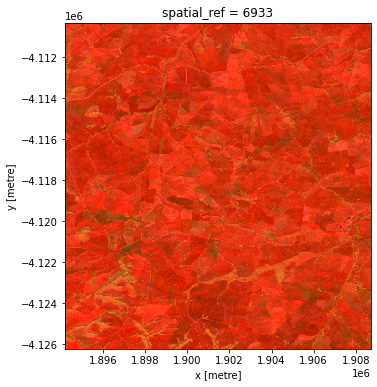

In [10]:
# Generate RGB plots at each timestep
rgb(tmad, bands=['sdev', 'edev', 'bcdev'])

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** August 2020

**Compatible datacube version:**

In [11]:
print(datacube.__version__)

1.8.2.dev7+gdcab0e02


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index]()